# Representational Similarity Analysis

Eggs and marshmallow are not kept next to each other in the grocery store despite being a similar color and size. The eggs are usually placed with dairy items and marshmallows with baking supplies. This helps us shop easily, as we usually group our shopping by categories: fruits and vegetables, meat and dairy, frozen foods, and, somewhere far away, kitchen supplies, toys and sports. How does the brain represent meaningful conceptual groupings? Are patterns of neural activity for marshmallows and chocolate chips more similar to each other as compared to the patterns for eggs and marshmallows?

The brain could conceivably group items based on attributes such as color and size. This would make the neural representations of marshmallows and eggs very similar to each other. In a brain region that cares about color, the neural similarity would be greater for white eggs and marshmallows, compared to white eggs and brown eggs. How can we determine the similarity between neural representations and which attributes are driving this similarity?

Representational similarity analysis (RSA) is a way to compare and contrast different brain states and the stimuli that elicited them. In RSA, we compute a similarity measure (often a correlation) between patterns of neural activity for all items being compared. Then, to examine whether neural patterns in a brain region are grouped by color, size, or category, we can order the similarity measure based on a model that groups by these attributes.

RSA is a highly versatile tool: it can be used to compare brain activity to models, compare data across brain imaging techniques, and even to make cross-species comparisons. You can learn more about the RSA method [here](https://doi.org/10.3389/neuro.06.004.2008) and [here](https://doi.org/10.1016/j.tics.2013.06.007).
    
## Goal of this script

>1. Learn how to perform RSA on a dataset
  >> Calculate and plot Pearson and Spearman correlations in ROIs  
  >> Order these similarity matrices in a meaningful way  
  >> Interpret a (dis)similarity matrix  
>2. Visualize similarity with multi dimensional scaling (MDS)

## Table of Contents  
[1. Prepare for RSA](#preprocessing)
>[1.1 Load the data for one subject](#load_data)  
>[1.2 Helper functions ](#helper)  
>[1.3 Visualize the data](#visualize_data)  

[2. Create a similarity matrix](#sim_mat)  
>[2.1 Reorder data into categories](#reorder)  
>[2.2 How to read a similarity matrix](#read_sim_mat)  
>[2.3 Representational dissimilarity](#read_dsim_mat)  
>[2.4 Comparison of representations in monkeys and humans](#rdm-monkey-human)  

[3. Multi-dimensional scaling (MDS)](#mds)   
>[3.1 Plotting the 2d structure of the RDM](#plot_2d)  
>[3.2 Plotting the 3d structure of the RDM](#plot_3d)  

[4. Unknown labels challenge](#challenge)   

Exercises
>[Exercise 1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)  [9](#ex9) [10](#ex10)

[Novel contribution](#novel)  

### Prepare for RSA <a id="preprocessing"></a> 

The dataset we will be using for this exercise is from [Kriegeskorte et al. (2008)](https://www.sciencedirect.com/science/article/pii/S0896627308009434), called 'Ninetysix' in the `datasets` folder. 96 visual stimuli, from the 6 categories listed below, were presented to participants. The image stimuli are stored in the subfolder `Stimuli`.

The data have 6 categories:     
    1. artificial inanimate (object/scene)    
    2. human bodypart     
    3. human face     
    4. natural inanimate (object/scene)    
    5. nonhuman bodypart    
    6. nonhuman face    

**Self-study:** Explore the data!

In [128]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline
sns.set(palette="colorblind", style = 'white', context='notebook', rc={"lines.linewidth": 2.5})

### 1.1 Load the data for one subject<a id="load_data"></a>

The data for these participants are stored as matlab files. Python can load matlab files using a scipy utility. However, the file formats can be tricky and may require transformations to make compatible with typical Python organization. 

The data from matlab are stored as a dictionary where the variables in the matlab files are keys in the dictionary:

>The ROI names are listed in `roinames`.       
>The category label indices for each condition are listed in `labels`.       
>The label indices correspond to entries in `categoryNames`.      
>The data for each ROI, in the order of `roinames`, is stored in `roi_data`.      

Each row of `roi_data` represents a stimulus (as defined in `labels`) and each column represents a voxel (there will be different numbers of voxels in different ROIs). These data have been preprocessed and each entry is stored in terms of t-values. There is no time information and no baseline signal to be used for reference.

**Self-study:** What do you think these t-values reflect?

In the analyses that follow we are going to explore the data of subject 'BE'. The last 4 rows of this dataset have unknown labels (dun dun dunnnnn!). We'll use only the first 92 rows for analysis, for now.



### 1.2 Helper Functions <a id="helper"> </a>

To make it easy for you to achieve the main goals of this notebook, we have created helper functions that extract data from matlab files and convert into numpy arrays.

In [129]:
from utils import load_data_for_a_subj, digitize_rdm, ns_data_dir

In [130]:
# Load the data for one subject
subj_initials = 'BE'
data_pack = load_data_for_a_subj(subj_initials)
images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
n_stimuli = len(images)

**Exercise 1:**<a id="ex1"></a> Inspect the data. 
- Print the name of each category.
- Report the shape of the data for each ROI and what each dimension means

In [131]:
# Insert code here
print(categories)
print(roi_names)
for i in roi_data:
    print(i.shape)

['artificial inanimate', 'human bodypart', 'human face', 'natural inanimate', 'nonhuman bodypart', 'nonhuman face']
['lFFA', 'rFFA', 'lPPA', 'rPPA']
(96, 34)
(96, 70)
(96, 348)
(96, 273)


The 96 refers to the number of visual stimuli for which BOLD response was measured and the second dimensions are the sizes of each ROI.

### 1.3 Visualize the data <a id="visualize_data"></a>

It is always a good idea to plot data as a sanity check before starting analysis. 

Text(0.5, 0, 't-Value')

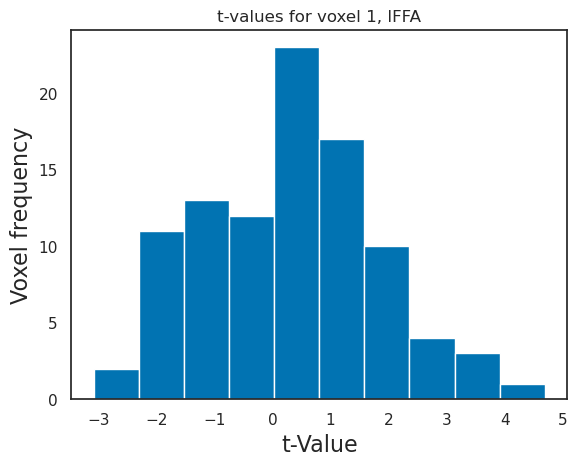

In [132]:
# Display the distribution of t-values for the first voxel in the first ROI
f, ax = plt.subplots()
ax.hist(roi_data[0][:, 0])
ax.set_title(f"t-values for voxel 1, {roi_names[0]}")
ax.set_ylabel('Voxel frequency', fontsize=16)
ax.set_xlabel('t-Value', fontsize=16)

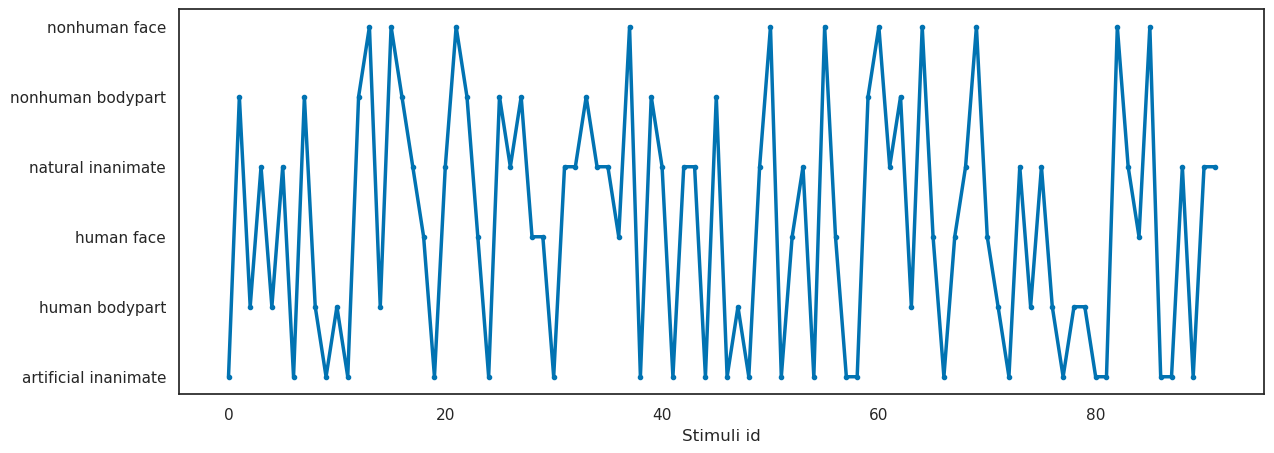

In [133]:
# We also want to see the timeline of different categories shown. 

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(labels,'.-')
ax.set_xlabel('Stimuli id')
ax.set_yticks(np.arange(len(categories))+1)
_=ax.set_yticklabels(categories)

<div class="alert alert-block alert-warning">
Notice that the category order is random i.e. the stimuli at every point are from a different category compared to the neighbors.
</div>

## 2. Create a similarity matrix <a id="sim_mat"></a>

Let's examine the similarity of the neural representations of each image with the neural patterns of every other image in the dataset. If the neural patterns are similar between images, we will see high values of similarity, but if the neural patterns are dissimilar, we will see low values of similarity. 

There are many ways to compute similarity. We start with one of the most common measures of similarity that you are already familiar with: Pearson correlation (see notebook-04). We compute the Pearson correlation on the neural pattern for each image with every other image. We can compute this on data for each of the ROIs that we have just loaded (left and right FFA, and left and right PPA). For each ROI, our computation will result in a 92 x 92 matrix (we only have labels for 92 images). This resulting matrix shows how similar the neural patterns of activity are between images and is called the representational **similarity** matrix (RSM).

Text(0, 0.5, 'Stimulus idx')

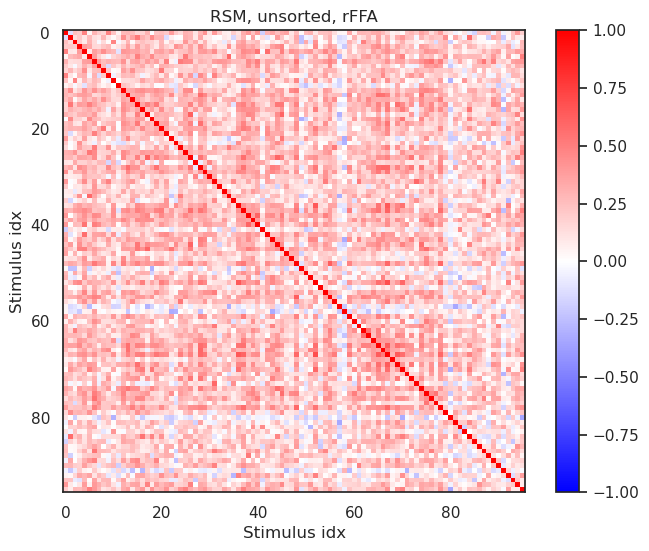

In [134]:
# Choose your ROI
my_roi = 'rFFA'
roi_id = roi_names.index(my_roi)

# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8,6))

plt.imshow(
    np.corrcoef(roi_data[roi_id]), 
    cmap='bwr', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()
ax.set_title(f'RSM, unsorted, {my_roi}') 
ax.set_xlabel('Stimulus idx')
ax.set_ylabel('Stimulus idx')

**Exercise 2:**<a id="ex2"></a> In the plot above we used Pearson correlation to compute similarity. Another similarity metric we could use is Spearman correlation. 

- Explain the difference between Pearson and Spearman correlation.
- Redo the analysis above (using the same data) with Spearman correlation.  
- Visualize the RSM based on Spearman correlation.  

**A:**  
Pearson correlation measures the strength of a linear relationship between two continuous variables, while Spearman correlation measures the strength of a monotonic relationship between two variables. Spearman correlation does not assume that data is from a specific distribution, so it is a non-parametric correlation measure. Spearman correlation computes correlation coefficient on rank values of the data. Pearson correlation is sensitive to outliers, while Spearman correlation is more robust to outliers.

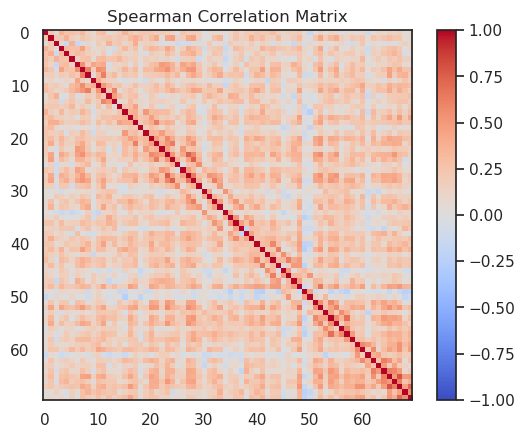

In [135]:
data = roi_data[roi_id]

# Calculate the Spearman correlation matrix
corr_matrix = stats.spearmanr(data)[0]

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix, cmap='coolwarm',
              vmin = -1, 
              vmax = 1)

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Add x and y axis labels and a title
ax.set_title("Spearman Correlation Matrix")

# Display the plot
plt.show()

### 2.1 Reorder data into categories <a id="reorder"></a>

Although the plot above is useful, it is hard to observe any structure because the order of the stimuli is random. To simplify, let's reorganize into label groups.

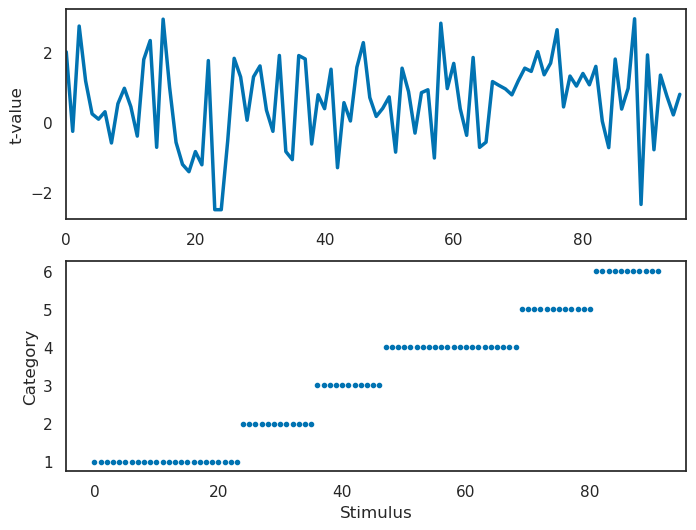

In [136]:
# Add the stimulus condition labels so that we can sort the data, collecting rows from the same condition together.
sort_ids = labels.argsort()
my_roi = 'rFFA'
roi_id = roi_names.index(my_roi)

data_sorted = roi_data[roi_id][sort_ids, :]

plt.figure(figsize=(8,6))

# Plot the new sorted results.
plt.subplot(2,1,1)
plt.plot(data_sorted[:, 0]) # Take a single voxel to visualize.
plt.ylabel('t-value')
plt.xlim(0, 96)

plt.subplot(2,1,2)
plt.plot(labels[sort_ids],'.')
plt.xlabel('Stimulus')
plt.ylabel('Category')
plt.show()


Text(0.5, 1.0, 'RSM, sorted, rFFA')

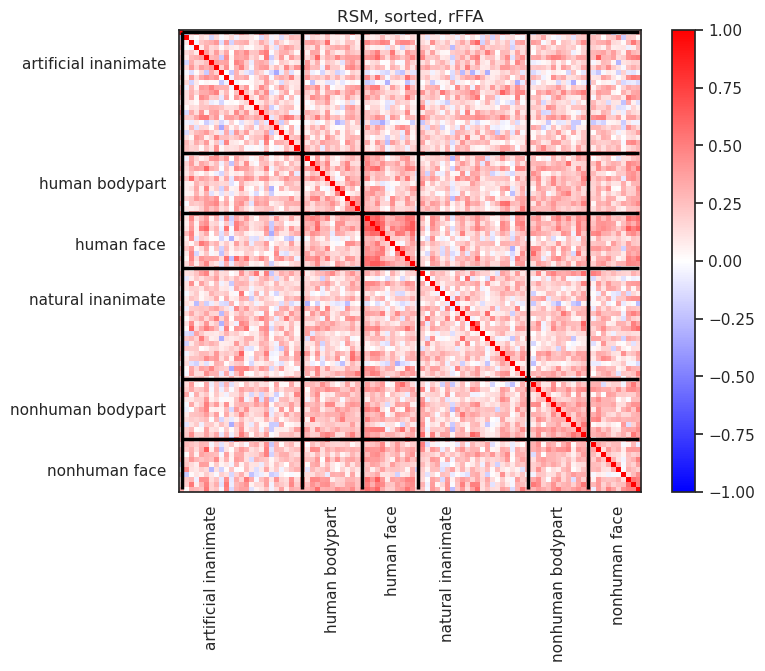

In [137]:
# Specify your ROI.
my_roi = 'rFFA'
roi_id = roi_names.index(my_roi)

# Calculate the RSM
rsm = np.corrcoef(roi_data[roi_id][sort_ids, :][:92,])

# Plot 
f, ax = plt.subplots(1,1, figsize=(8,6))
plt.imshow(
    rsm, 
    cmap='bwr', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()

# Pull out the bin edges between the different categories.
binsize = np.histogram(labels[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+6))
ax.set_title(f'RSM sorted by category, {my_roi}') 
ax.set_xticklabels(categories, rotation = 90)
ax.set_yticks(list(np.array(edges)+6))
ax.set_yticklabels(categories)
ax.vlines(edges,0,91, 'black')
ax.hlines(edges,0,91, 'black')
ax.set_title(f'RSM, sorted, {my_roi}')

<div class="alert alert-block alert-warning">
<strong>Binning the data:</strong> In Figure 1 of Kriegeskorte et al. (2008), the raw correlation values were binned into ten bins based on the percentile score of the dissimilarity value, and the percentile value was plotted. We have created a function `digitize_rdm` to perform the same calculation here and make the plots similar to Figure 1 in Kriegeskorte et al. (2008). 
<br>    
<br>
Note that Figure 1 was using dissimilarity rather than similarity and that the data were from a different ROI (inferior temporal cortex, or IT). However, we can apply the same function to our RSM, the only difference being that the percentile will be based on similarity. 
<br>    
<br>
The `digitize_rdm` functions works in the following manner:  
<br>    
<br>
1. Create `n_bins` of percentile values.  <br>
2. Take in the matrix of correlations and reshape it into a single row. <br> 
3. Determine the percentile value of every correlation point and assign it to a bin (`np.digitize` does this).  <br>
4. Reshape the assigned percentile values into the original correlation matrix shape.  <br>
5. Finally, plot the percentile values.<br>
<br>
</div>

Text(0.5, 1.0, 'RSM digitized rFFA')

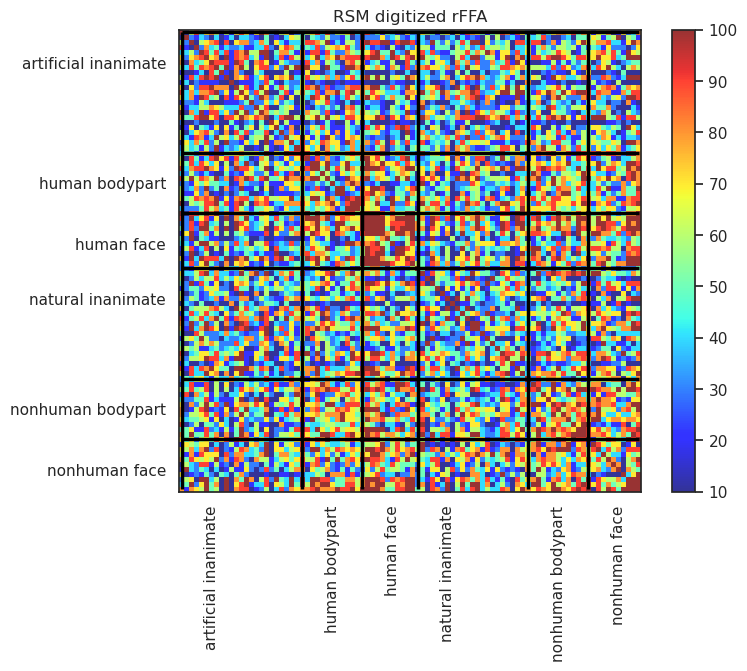

In [138]:
# Plot the digitized RSM
f, ax = plt.subplots(1,1, figsize=(8,6))
plt.imshow(
    digitize_rdm(rsm), cmap='jet', alpha=0.8
)
clb = plt.colorbar()
clb.ax.set_xlabel("Percentile of similarity")
# Pull out the bin edges between the different categories
binsize = np.histogram(labels[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+6))
ax.set_xticklabels(categories, rotation = 90)
ax.set_yticks(list(np.array(edges)+6))
ax.set_yticklabels(categories)
ax.vlines(edges,0,91,'black')
ax.hlines(edges,0,91,'black')
ax.set_title(f'RSM digitized {my_roi}')

**Exercise 3:**<a id="ex3"></a> This new organization is helpful but could be improved (based on our knowledge of the brain). Order the datapoints so that the categories are as follows: artificial inanimate, natural inanimate, non-human body part, non-human face, human body part, human face.  This will make for a nicer looking correlation matrix and will help you see any structure within and between categories. 

- Write a function to re-order the data called `reorder_data` that takes three parameters: `data`, `labels`, and `new_category_order` and returns `reordered_data` and `reordered_labels`. Include docstring commenting for this function.
- Recompute the RSM for the rFFA based on the re-ordered data (call it `reordered_rsm`) and visualize it.
- Digitize and visualize `reordered_rsm` using the digitization function provided earlier. 

In [139]:
# Insert code here
NCO = [1,4,5,6,2,3]

def reorder_data(data, labels, new_category_order):
    
    """
    This function reorders the data according to a new set of category labels.
    
    Parameters:
        data (array): Activation data for a specified ROI
        labels (array): Current category label ordering
        new_category_order (array): The desired output ordering of category labels.
        
    Returns:
        reordered_data (array): the data parameter after being reordered according to the new category order.
        reordered_labels (array): new category label order
    """
    
    idx_reorder = []
    for cat in new_category_order:
        idx  = np.where(labels == cat)[0]
        idx_reorder += list(idx)
    reordered_data = data[idx_reorder]
    reordered_labels = labels[idx_reorder]

    return reordered_data, reordered_labels

reorderedData, reorderedLabels = reorder_data(roi_data[roi_id][:92], labels[:92], NCO)
print(roi_data[roi_id].shape)

(96, 70)


Text(0.5, 1.0, 'reordered RSM digitized rFFA')

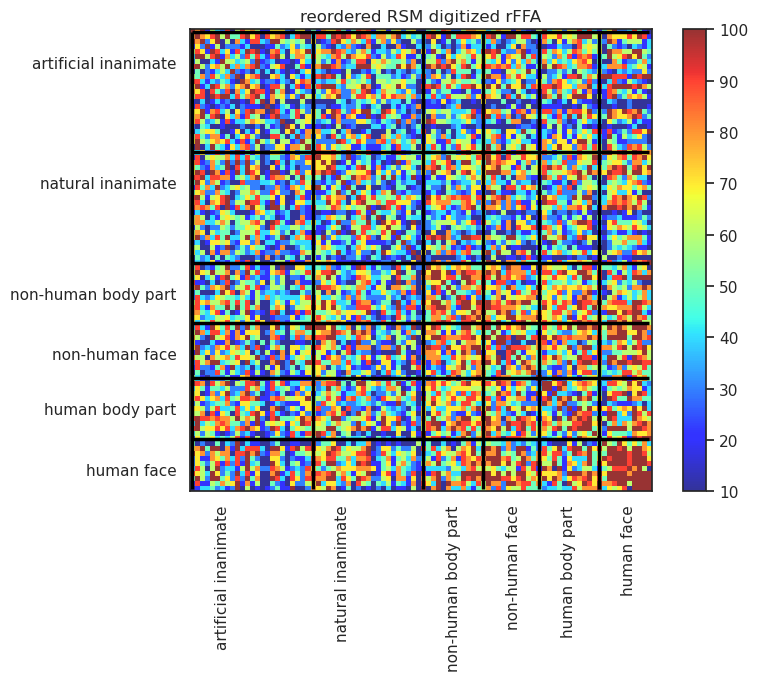

In [140]:
# Plot the digitized RSM
f, ax = plt.subplots(1,1, figsize=(8,6))
plt.imshow(
    digitize_rdm(np.corrcoef(reorderedData)), cmap='jet', alpha=0.8
)

new_cats = ["artificial inanimate", "natural inanimate", "non-human body part", "non-human face", "human body part", "human face"]
clb = plt.colorbar()
clb.ax.set_xlabel("Percentile of similarity")
# Pull out the bin edges between the different categories
binsize = np.histogram(labels[:92,], 6)[0]
binsize_sorted = [binsize[i-1] for i in NCO]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize_sorted)])[:-1]
ax.set_xticks(list(np.array(edges)+6))
ax.set_xticklabels(new_cats, rotation = 90)
ax.set_yticks(list(np.array(edges)+6))
ax.set_yticklabels(new_cats)
ax.vlines(edges,0,91,'black')
ax.hlines(edges,0,91,'black')
ax.set_title(f'reordered RSM digitized {my_roi}')

### 2.2 How to read a similarity matrix <a id="read_sim_mat"></a>

It is important to be able to read a similarity matrix at a glance. There are couple features to look out for and we will highlight these with some toy data.

Imagine a scenario where we have 12 trial types (e.g., images) grouped into 4 categories (e.g., faces, objects, body parts, and scenes). We are going to simulate some data that has similar activity within category but different activity between categories.

#### 2.2.1. Create simulated data. 

In [141]:
trial_types = 12
n_sim_categories = 4
repetitions_per_trial = 24
trial_noise = 0.5 # Multiplying factor for the noise for each trial.
trials_per_category = int(trial_types / n_sim_categories)

# The template per category. One common signal per category. 
# This will be the similarity within category.
category_templates = np.random.randn(n_sim_categories, repetitions_per_trial)

# Add some noise to each trial and add the category template to each trial.
# This will create the trial activity.
trials = np.zeros((trial_types, repetitions_per_trial))
for category_counter in range(n_sim_categories):
    category_trials = np.random.randn(trials_per_category, repetitions_per_trial) * trial_noise
    for trial_counter in range(trials_per_category):
        trials[(trials_per_category * category_counter) + trial_counter, :] = category_templates[category_counter, :] + category_trials[trial_counter, :]

#### 2.2.2. Compute correlation and plot the result

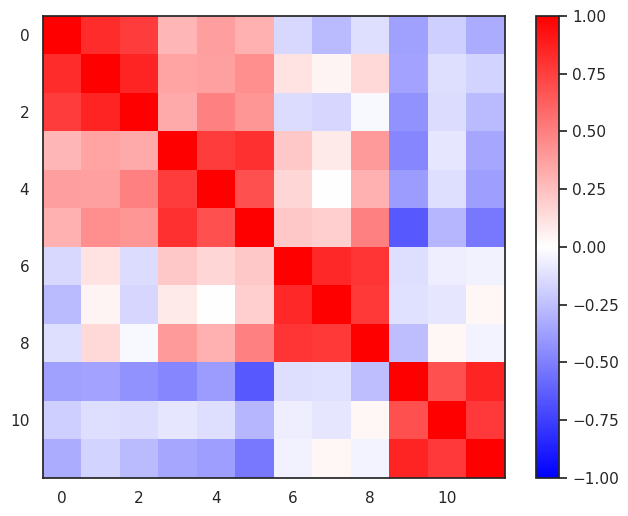

In [142]:
# Create the correlation matrix    
sim_r1 = np.corrcoef(trials)
plt.figure(figsize=(8, 6))
plt.imshow(sim_r1, 
           interpolation='none',
           cmap='bwr', 
           vmin=-1,
           vmax=1,
          )
plt.colorbar()

In the above plot you should see some clear blocking structure along the diagonal: items within a category are more similar to one another than they are to items in different categories.

#### 2.2.3. Make two categories similar and observe changes in the similarity matrix 

Below we create a plot where there is off-diagonal structure. High similarity in off-diagonal parts of a similarity matrix means that elements that are far apart in the ordering have similar structure. In this toy simulation we create an example where the first and third categories are similar to one another (i.e., faces and body parts).

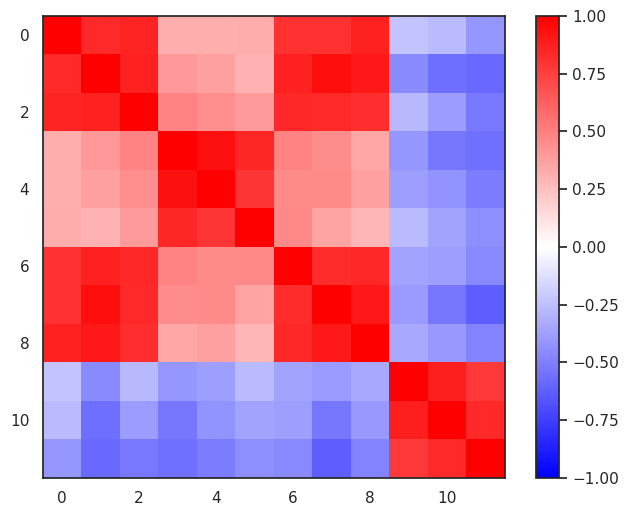

In [143]:
# Overwrite the template for the 3rd category with the template for 1st category. 
category_templates[2, :] = category_templates[0, :]

# Create the trial activity.
trials = np.zeros((trial_types, repetitions_per_trial))
for category_counter in range(n_sim_categories):
    category_trials = np.random.randn(trials_per_category, repetitions_per_trial) * trial_noise
    for trial_counter in range(trials_per_category):
        trials[(trials_per_category * category_counter) + trial_counter, :] = category_templates[category_counter, :] + category_trials[trial_counter, :]

# Create the correlation matrix.    
sim_r2 = np.corrcoef(trials)
plt.figure(figsize=(8, 6))
plt.imshow(sim_r2, 
           interpolation='none',
           cmap='bwr', 
           vmin=-1,
           vmax=1,
          )
plt.colorbar()

**Exercise 4:**<a id="ex4"></a> Now that you know how to read a similarity matrix, interpret the matrix that you created for the real data in [Exercise 3](#ex3).

**A:**  
All face images invoked very strongly similar responses in the rFFA, which is logical as it is a region associated with facial recognition. In addition, all the images of living things (human and non human, body part or face) all had some degree of similarity to each other more so than they did to inanimate objects.

### 2.3 Representational dissimilarity <a id="read_dsim_mat"></a>

The previous analyses focused on the *similarity* between the items. Sometimes we prefer to consider our data in terms of the *dissimilarity* between items. This close cousin of the representational similarity matrix (RSM) is called the *representational dissimilarity matrix* (RDM). The RDM is computed as simply `1 - correlation`, or *correlation distance*, between pairs of items.

**Exercise 5:**<a id="ex5"></a> Plot the digitized RDM for the right FFA ROI using the new order as you created in [Exercise 3](#ex3).

Text(0.5, 1.0, 'reordered RDM digitized rFFA')

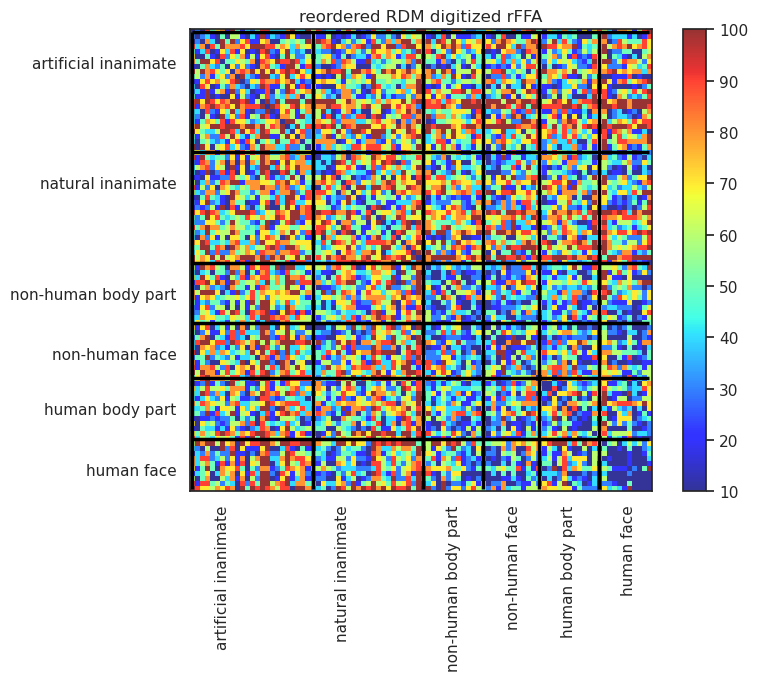

In [144]:
# Insert code here.
# Plot the digitized RDM
f, ax = plt.subplots(1,1, figsize=(8,6))
plt.imshow(
    digitize_rdm(1-(np.corrcoef(reorderedData))), cmap='jet', alpha=0.8
)

new_cats = ["artificial inanimate", "natural inanimate", "non-human body part", "non-human face", "human body part", "human face"]
clb = plt.colorbar()
clb.ax.set_xlabel("Percentile of similarity")
# Pull out the bin edges between the different categories
binsize = np.histogram(labels[:92,], 6)[0]
binsize_sorted = [binsize[i-1] for i in NCO]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize_sorted)])[:-1]
ax.set_xticks(list(np.array(edges)+6))
ax.set_xticklabels(new_cats, rotation = 90)
ax.set_yticks(list(np.array(edges)+6))
ax.set_yticklabels(new_cats)
ax.vlines(edges,0,91,'black')
ax.hlines(edges,0,91,'black')
ax.set_title(f'reordered RDM digitized {my_roi}')

**Exercise 6:**<a id="ex6"></a> In an RDM, what does it mean if two items have a RDM value of 0? What does it mean if they have a value of 1?

**A:**  
in an RDM, a value of 0 means that the two items were identical and a value of 1 means they were completely dissimilar.

### 2.4 Comparison of representations in monkeys and humans <a id="rdm-monkey-human"></a>

Representational similarity analysis can be used to compare information from the same source, e.g. human to human, but also across sources -- e.g. human to monkey or human to computer model. Below is comparison of the RDM for monkeys and humans, in the inferior temporal cortex. (Color map altered to match Figure 1 in Kriegeskorte et al. (2008)).

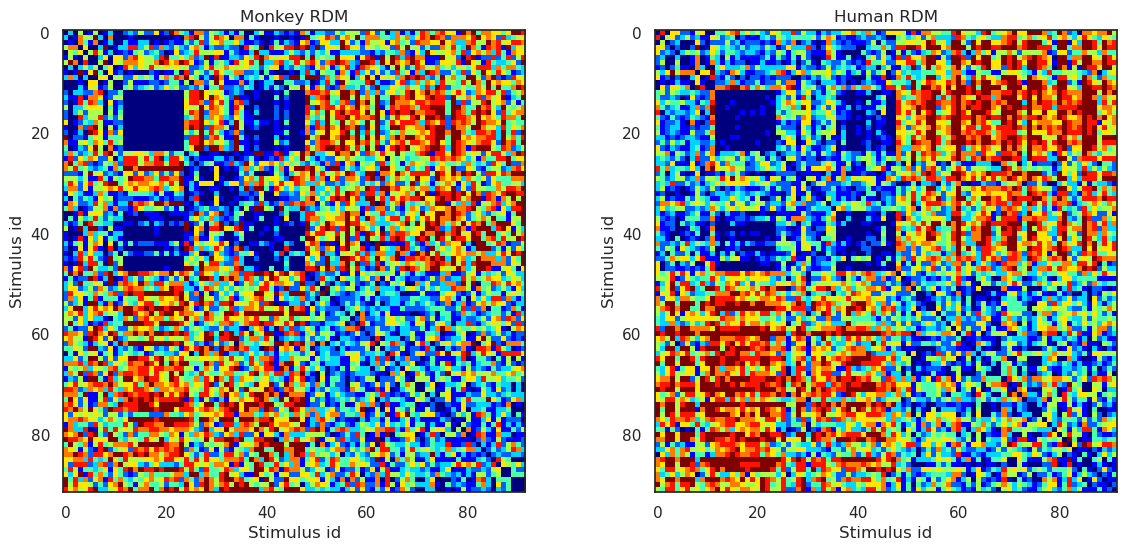

In [145]:
# Load the data, and bin to percentile
monkeyRDM = pd.read_csv(os.path.join(ns_data_dir, 'RDM_mIT_fig1.txt'), header=None)
humanRDM = pd.read_csv(os.path.join(ns_data_dir, 'RDM_hIT_fig1.txt'), header=None)

monkey_rdm_digitized = digitize_rdm(monkeyRDM)
human_rdm_digitized = digitize_rdm(humanRDM)

f, axes = plt.subplots(1,2, figsize = (14, 6))
axes[0].imshow(
    monkey_rdm_digitized, 
    cmap='jet', 
)
axes[1].imshow(
     human_rdm_digitized, 
     cmap='jet', 
)
axes[0].set_title('Monkey RDM')
axes[1].set_title('Human RDM')

for i in range(2): 
    axes[i].set_xlabel('Stimulus id')
    axes[i].set_ylabel('Stimulus id')

## 3. Multi-dimensional scaling (MDS) <a id="mds"></a>

The correlation matrix for the 92 images describes how similar each item is to each other item. This means that if two items have a high positive correlation then they can be thought of as eliciting a very similar activation pattern across voxels. We can reframe this to be thought of as a distance in a high-dimensional space. From this perspective, items that are similar to one another will be grouped close together and far away from points that they are dissimilar to. 

MDS allows us to visualize the similarity of our data in a different way than plotting the matrices above. Specifically, it allows to generate a lower-dimensional image (e.g., 2-D or 3-D) in which the distances between points approximate the distances in the original high-dimensional data. There is an MDS [method](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Multidimensional_Scaling.pdf) built into [scikit-learn](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling).

In [146]:
# Create a 2-D MDS
rsm = np.corrcoef(roi_data[roi_id][:92])
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)  # Create the MDS object
results = mds.fit(digitize_rdm(1 - rsm))  # Use the dissimilarity matrix

**Self study:** Investigate the items returned from fitting the MDS model. Print out some of the items when you run the following line.

In [147]:
results?

Type:        MDS
String form: MDS(dissimilarity='precomputed', random_state=0)
File:        /gpfs/gibbs/project/cmhn/share/conda_envs/mybrainiak/lib/python3.7/site-packages/sklearn/manifold/_mds.py
Docstring:  
Multidimensional scaling.

Read more in the :ref:`User Guide <multidimensional_scaling>`.

Parameters
----------
n_components : int, default=2
    Number of dimensions in which to immerse the dissimilarities.

metric : bool, default=True
    If ``True``, perform metric MDS; otherwise, perform nonmetric MDS.

n_init : int, default=4
    Number of times the SMACOF algorithm will be run with different
    initializations. The final results will be the best output of the runs,
    determined by the run with the smallest final stress.

max_iter : int, default=300
    Maximum number of iterations of the SMACOF algorithm for a single run.

verbose : int, default=0
    Level of verbosity.

eps : float, default=1e-3
    Relative tolerance with respect to stress at which to declare
    co

### 3.1 Plot the 2D structure of the RDM <a id="plot_2d"></a>

We'll plot the 92 images on a "map" signifying how close or far apart images are to each other. We use different colors for the 6 categories of images.

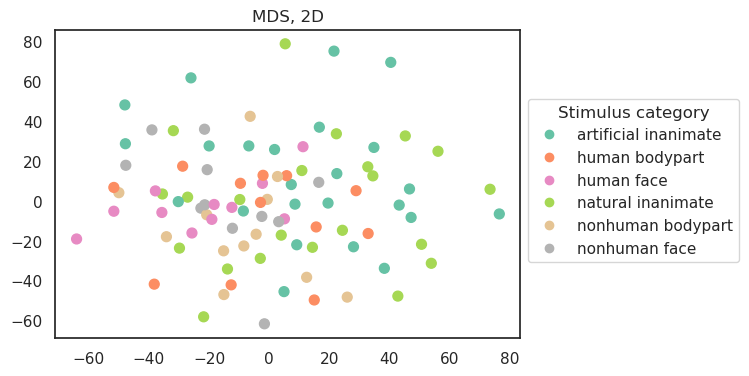

In [148]:
coords = results.embedding_
fig,ax=plt.subplots(figsize=(6,4))
scatter = ax.scatter(coords[:,0], coords[:,1], c=labels[:92], cmap='Set2', s = 50)
handles, labels1 = scatter.legend_elements()
legend2 = ax.legend(handles, categories, bbox_to_anchor=(1, .8),loc="upper left",title='Stimulus category')
plt.title('MDS, 2D');

**Exercise 7:**<a id="ex7"></a> How does fitting MDS with a raw RDM differ from a digitized one? What about an RSM versus and RDM? *Hint: think about scaling.*


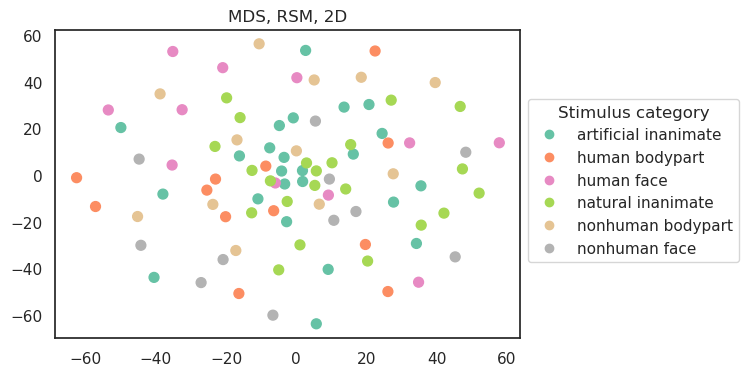

In [149]:
# Insert code here.

# Create a 2-D RSM MDS

rsm = np.corrcoef(roi_data[roi_id][:92])
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)  # Create the MDS object
results = mds.fit(digitize_rdm(rsm))  # Use the similarity matrix

coords = results.embedding_
fig,ax=plt.subplots(figsize=(6,4))
scatter = ax.scatter(coords[:,0], coords[:,1], c=labels[:92], cmap='Set2', s = 50)
handles, labels1 = scatter.legend_elements()
legend2 = ax.legend(handles, categories, bbox_to_anchor=(1, .8),loc="upper left",title='Stimulus category')
plt.title('MDS, RSM, 2D');

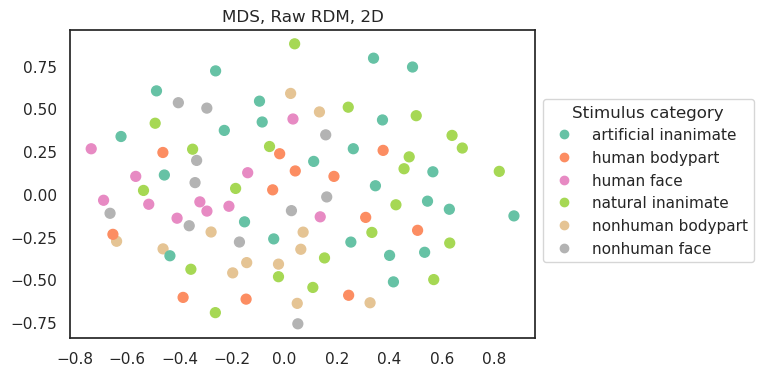

In [150]:
# Create a 2-D Raw RDM MDS

rsm = np.corrcoef(roi_data[roi_id][:92])
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)  # Create the MDS object
results = mds.fit(1 - rsm)  # Use the dissimilarity matrix

coords = results.embedding_
fig,ax=plt.subplots(figsize=(6,4))
scatter = ax.scatter(coords[:,0], coords[:,1], c=labels[:92], cmap='Set2', s = 50)
handles, labels1 = scatter.legend_elements()
legend2 = ax.legend(handles, categories, bbox_to_anchor=(1, .8),loc="upper left",title='Stimulus category')
plt.title('MDS, Raw RDM, 2D');

**A:**  
For digitized vs raw RDM: Fitting an MDS with raw RDM results in a smaller range of dispersion as all values are between -1 and 1, in line with 1 - correlation which is used to derive it. Digitization of RDM results in a range of numbers from -60 to 80, which makes sense as digitization exaggerates the distances between the points according to assigned percentile values.

For RSM vs RDM: We see that fitting an MDS with RSM as opposed to RDM simply turns the MDS inside out centered at (0,0). Points closer to the center in one are pushed to the edges of the plot in the other. This is logically consistent as RDM = 1 - RSM.

**Self-study**: On the MDS plot you are currently plotting each item as a point. You could instead load in each image and plot that image on the MDS plot directly to get a feel for which stimuli are being grouped.

### 3.2 Plot the 3D structure of the RDM <a id="plot_3d"></a>

MDS is just trying to find a k-dimensional embedding that minimizes the stress, which can be thought of as a metric of goodness-of-fit (for more information, [these slides](https://www.stat.pitt.edu/sungkyu/course/2221Fall13/lec8_mds_combined.pdf) have a nice background on MDS) (something akin to the goodness of fit). This means we can actually plot it in arbitrarily high dimensions to try and capture the data structure. Below we make a 3D plot.

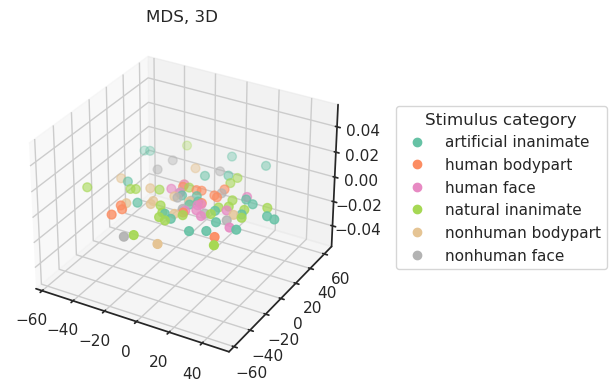

In [151]:
# Multi-dimensional scaling
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
results = mds.fit(digitize_rdm(1 - rsm))

coords = results.embedding_
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(coords[:,0], coords[:,1], c=labels[:92], cmap='Set2', s = 40)
handles, labels1 = scatter.legend_elements()
legend2 = ax.legend(handles, categories, bbox_to_anchor=(1.1, .8), 
                    loc="upper left",title='Stimulus category')
plt.title('MDS, 3D')
plt.tight_layout()

There are tools available to us to evaluate what is the appropriate dimensionality for visualization of our data (i.e. what dimensionality has sufficiently low stress). We can look at the stress of the MDS with different numbers of components (i.e. different dimensionality) and determine what dimensionality of the data is appropriate.

Let's make a toy problem to start off with in order to get a handle on what this should look like. We are going to make points that lie on a line in 3D space. Because a line has only one dimension of information (along its length) the data ought to be able to be reduced in dimensionality to a single dimension. We will run MDS on this data to see if that is the case.

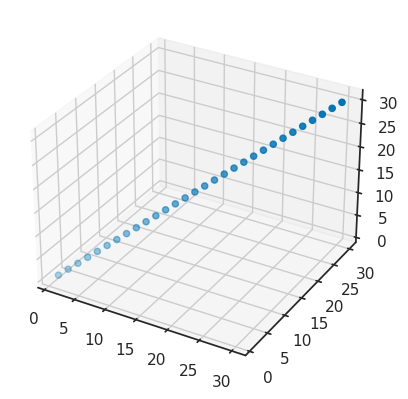

In [152]:
coords = np.linspace(1, 30, 30)
coords = np.vstack((coords, coords, coords)).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2])

Text(0.5, 0, 'Dimensionality')

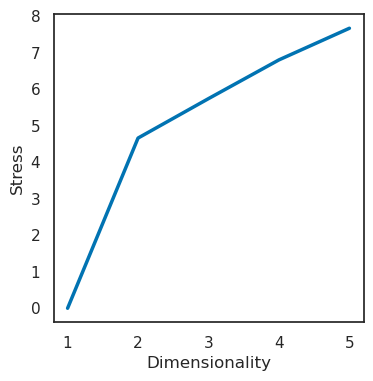

In [153]:
# Calculate the euclidean distance of every point from every other point.
dist = sp_distance.squareform(sp_distance.pdist(coords))

# Iterate through different numbers of components.
stress = []
for components in range(1, 6):
    mds = MDS(n_components=components, dissimilarity="precomputed", random_state=0)
    # Pull out the stress of the MDS fit.
    stress.append(mds.fit(dist).stress_)

# Plot the stress.
plt.figure(figsize=(4,4))
plt.plot(range(1, 6), stress)
plt.ylabel('Stress')
plt.xlabel('Dimensionality')

**Exercise 8:**<a id="ex8"></a> Typically, high dimensional data aren't described perfectly in low dimensionality; stress generally decreases with the number of components. Perform a similar analysis as we did with the toy data, now using data from the right FFA, testing n_components between 1 and 20. Plot stress as a function of number of components. Where does this curve begin to plateau?  

*Note: Calculate MDS fit from the RDM, then calculate stress from the fitted MDS object.*

MDS documentation: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html 

Here's the list of arguments for MDS: 
```
MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity=’euclidean’)
```

Text(0.5, 0, 'Dimensionality')

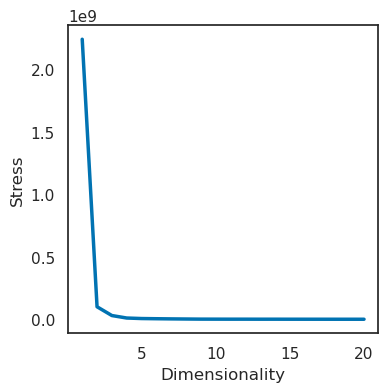

In [154]:
# Insert code here.
rsm = np.corrcoef(roi_data[roi_id][:92])

# Iterate through different numbers of components.
stress = []
for n in range(1, 21):
    mds = MDS(n_components=n, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity="euclidean")
    results_rdm_digitized = mds.fit(digitize_rdm(1-rsm))
    coords = results_rdm_digitized.embedding_
    dist = sp_distance.squareform(sp_distance.pdist(coords))
    
    # Pull out the stress of the MDS fit.
    stress.append(mds.fit(dist).stress_)

# Plot the stress.
plt.figure(figsize=(4,4))
plt.plot(range(1, 21), stress)
plt.ylabel('Stress')
plt.xlabel('Dimensionality')

**A:**  
It begins to plateau around 4 components.

**Exercise 9:**<a id="ex9"></a> Compute RDMs and create MDS plots for the left FFA and the left PPA using the reordering you created in [Exercise 3](#ex3). 

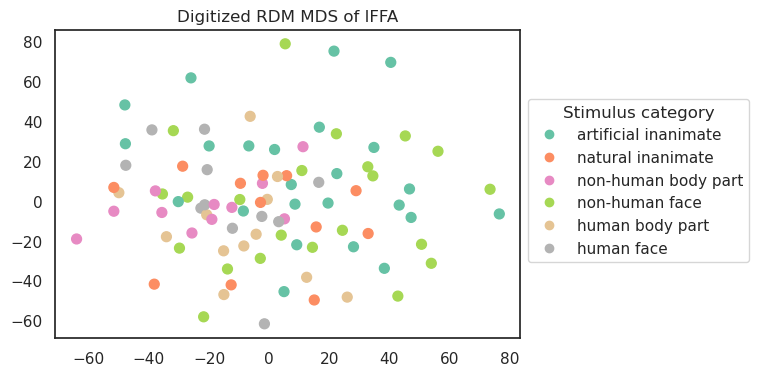

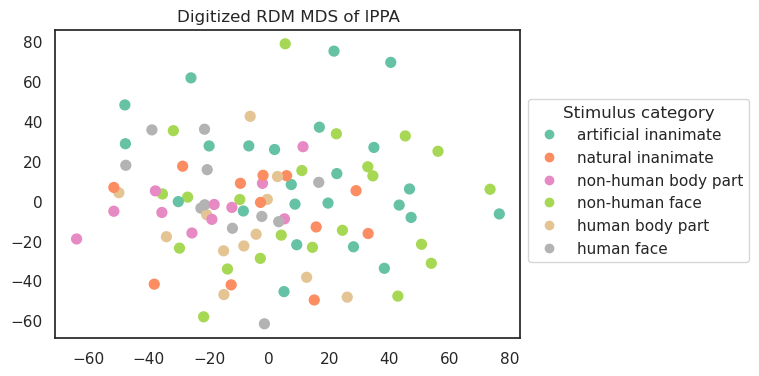

In [155]:
# Insert code here

#left FFA
my_roi = 'lFFA'
roi_id = roi_names.index(my_roi)
reorderedlFFAData, reorderedlFFALabels = reorder_data(roi_data[roi_id][:92], labels[:92], NCO)

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)  # Create the MDS object
resultslFFA = mds.fit(digitize_rdm(1 - rsm))  # Use the dissimilarity matrix
coords =resultslFFA.embedding_

fig,ax=plt.subplots(figsize=(6,4))
scatter = ax.scatter(coords[:,0], coords[:,1], c=labels[:92], cmap='Set2', s = 50)
handles, labels1 = scatter.legend_elements()
legend2 = ax.legend(handles, new_cats, bbox_to_anchor=(1, .8),loc="upper left",title='Stimulus category')
plt.title('Digitized RDM MDS of lFFA');

#left PPA
my_roi = 'lPPA'
roi_id = roi_names.index(my_roi)
reorderedlPPAData, reorderedlPPALabels = reorder_data(roi_data[roi_id][:92], labels[:92], NCO)

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)  # Create the MDS object
resultslPPA = mds.fit(digitize_rdm(1 - rsm))  # Use the dissimilarity matrix
coords =resultslPPA.embedding_

fig,ax=plt.subplots(figsize=(6,4))
scatter = ax.scatter(coords[:,0], coords[:,1], c=labels[:92], cmap='Set2', s = 50)
handles, labels1 = scatter.legend_elements()
legend2 = ax.legend(handles, new_cats, bbox_to_anchor=(1, .8),loc="upper left",title='Stimulus category')
plt.title('Digitized RDM MDS of lPPA');

## 4. Unknown labels challenge <a id="challenge"></a>

**Exercise 10:** <a id="ex10"></a>The last four rows in the dataset for subject BE have unmarked labels. One of them is a human face. Using the techniques outlined here and your knowledge of the category preference of each ROI, analyze the data to make a best guess of which one of the 4 missing labels is a human face. Show your work and reasoning that led you to this conclusion. Hint: It may help to visualize these 4 points amongst the points you already have. It may also help to compare these with a canonical "face" response.

Text(27.315135937908764, -49.08432820796978, 'img 96')

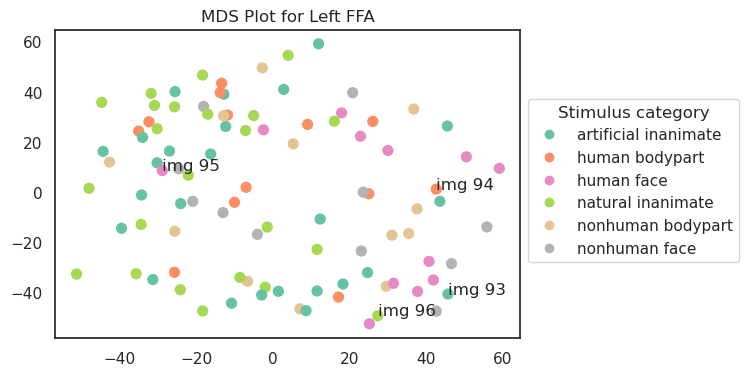

In [156]:
# Insert code here

# Create labels for unknown
ulabels = labels[:92]
ulabels = np.append (ulabels, 1)
ulabels = np. append (ulabels, 2)
ulabels = np. append (ulabels, 3)
ulabels = np. append (ulabels, 4)

ucategories = ['artificial inanimate',
'human bodypart', 'human face', 'natural inanimate',
'nonhuman bodypart', 'nonhuman face', 'unknown']

#lFFA plot
my_roi = 'lFFA'
roi_id = roi_names.index(my_roi)

rsm = np. corrcoef (roi_data[roi_id][: 96])
mds = MDS (n_components=2, dissimilarity="precomputed", random_state=0)
results = mds. fit (digitize_rdm(1-rsm) )
coords = results. embedding_


# Create scatterplot
fig, ax=plt.subplots (figsize= (6,4))
scatter = ax.scatter (coords [:, 0], coords[:, 1], c=ulabels[: 96], cmap= 'Set2', s = 50)
handles, labels1 = scatter.legend_elements()
ulegend = ax.legend (handles, ucategories, bbox_to_anchor= (1, .8), loc="upper left", title='Stimulus category')
plt.title( 'MDS Plot for Left FFA');

# Plot label-unknown data
plt.annotate ('img 93', xy=(coords[92,0],coords[92,1])) 
plt.annotate ('img 94', xy=(coords[93,0],coords[93,1])) 
plt.annotate ('img 95', xy=(coords[94,0],coords[94,1])) 
plt.annotate ('img 96', xy=(coords[95,0],coords[95,1]))

Based off of this, it seems that image 96 and image 93 are close to the cluster of human-face-labelled data plotted with img 94 being slightly less likely but still plausibly a human face object.

Text(-14.92719641560092, -14.67957978957551, 'img 96')

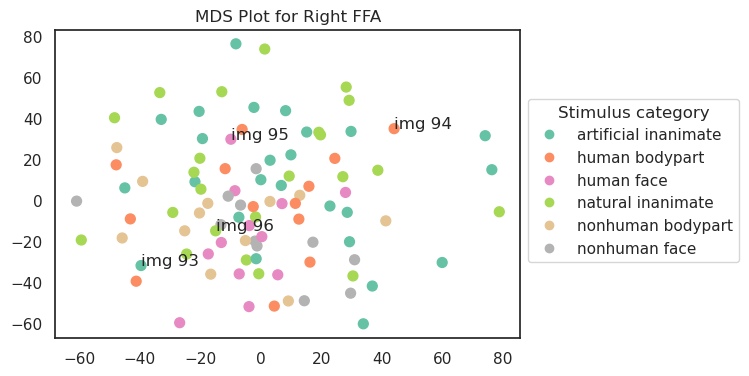

In [157]:
#rFFA plot
my_roi = 'rFFA'
roi_id = roi_names.index(my_roi)

rsm = np. corrcoef (roi_data[roi_id][: 96])
mds = MDS (n_components=2, dissimilarity="precomputed", random_state=0)
results = mds. fit (digitize_rdm(1-rsm) )
coords = results. embedding_


# Create scatterplot
fig, ax=plt.subplots (figsize= (6,4))
scatter = ax.scatter (coords [:, 0], coords[:, 1], c=ulabels[: 96], cmap= 'Set2', s = 50)
handles, labels1 = scatter.legend_elements()
legend2 = ax.legend (handles, categories2, bbox_to_anchor= (1, .8), loc="upper left", title='Stimulus category')
plt.title( 'MDS Plot for Right FFA');

# Plot label-unknown data
plt.annotate ('img 93', xy=(coords[92,0],coords[92,1])) 
plt.annotate ('img 94', xy=(coords[93,0],coords[93,1])) 
plt.annotate ('img 95', xy=(coords[94,0],coords[94,1])) 
plt.annotate ('img 96', xy=(coords[95,0],coords[95,1]))

Here we see that img 96 is centered nearly perfectly at the center of the cluster of human-face-labelled data points, suggesting img 96 is the one that is most likely a human face.

After running an analysis on the left and right FFAs, ROIs strongly associated with facial recognition, we see that img 96 is plotted on an MDS plot most closely to other human face plots, giving us reason to believe it is the most likely of the 4 unknown labels to be a human face.

**Novel contribution:**<a id="novel"></a>  be creative and make one new discovery by adding an analysis, visualization, or optimization.

Some examples:  

- visualize the average RDM across subjects
- compare the empirical RDM to some theoretical RDM
- check the consistency between hierarchical clustering vs. ground truth label ordering 
- use other dimensionality reduction methods to visualize the data (PCA, tSNE, etc.)
- perform some classification on this data set
- apply RSA on previous datasets (e.g. VDC, the simulated dataset used in the 1st notebook)
- apply RSA on previous datasets (e.g., VDC)
- even better, your own ambitious ideas! 

In [158]:
# Specify your ROI.
my_roi = 'rPPA'
roi_id = roi_names.index(my_roi)

# Calculate the RSM
rsm = np.corrcoef(roi_data[roi_id][sort_ids, :][:92,])

# Insert code here
NCO = [1,4,5,6,2,3]

def reorder_data(data, labels, new_category_order):
    
    idx_reorder = []
    for cat in new_category_order:
        idx  = np.where(labels == cat)[0]
        idx_reorder += list(idx)
    reordered_data = data[idx_reorder]
    reordered_labels = labels[idx_reorder]

    return reordered_data, reordered_labels

reorderedData, reorderedLabels = reorder_data(roi_data[roi_id][:92], labels[:92], NCO)
print(roi_data[roi_id].shape)

(96, 273)


Text(0.5, 1.0, 'reordered RSM digitized rPPA')

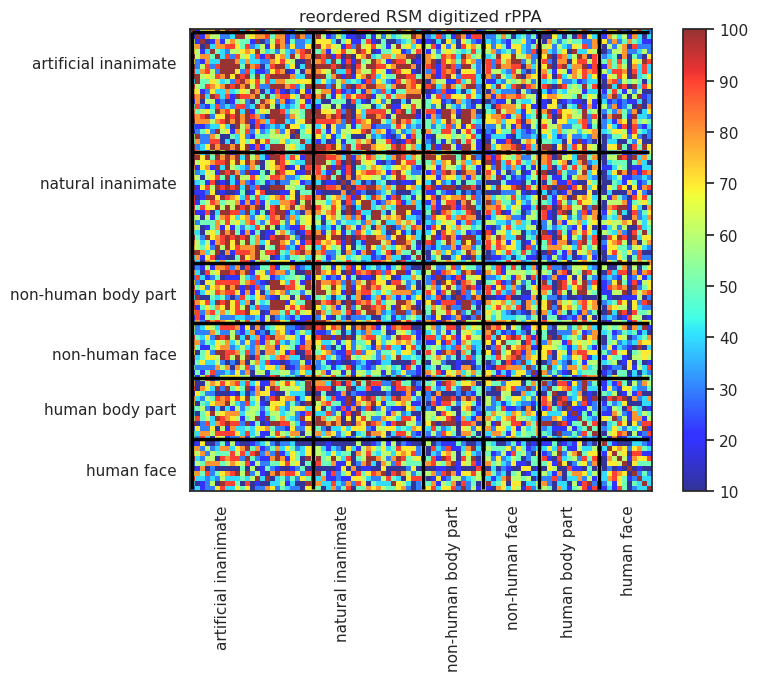

In [159]:
# Plot the digitized RSM
f, ax = plt.subplots(1,1, figsize=(8,6))
plt.imshow(
    digitize_rdm(np.corrcoef(reorderedData)), cmap='jet', alpha=0.8
)

new_cats = ["artificial inanimate", "natural inanimate", "non-human body part", "non-human face", "human body part", "human face"]
clb = plt.colorbar()
clb.ax.set_xlabel("Percentile of similarity")
# Pull out the bin edges between the different categories
binsize = np.histogram(labels[:92,], 6)[0]
binsize_sorted = [binsize[i-1] for i in NCO]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize_sorted)])[:-1]
ax.set_xticks(list(np.array(edges)+6))
ax.set_xticklabels(new_cats, rotation = 90)
ax.set_yticks(list(np.array(edges)+6))
ax.set_yticklabels(new_cats)
ax.vlines(edges,0,91,'black')
ax.hlines(edges,0,91,'black')
ax.set_title(f'reordered RSM digitized {my_roi}')

Here we visualize the similarity matrix for the right PPA region in which we see significantly worse facial recognition prediction, with all the human face and body part images being particularly dissimilar compared to each other. 

We do see slightly higher similarity values in the PPA as compared to the FFA for images labelled as representing inanimate objects. This may suggest linkage with the PPA and the perception of non-living objects and environments like scenes.

## Contributions <a id="contributions"></a> 

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook. 02/2018   
The mystery label exercise was borrowed from a matlab version created by F. Pereira.  
T. Meissner minor edits.  
Q. Lu plot aesthetics, digitization func, modularize funcs, re-ordering, replicate the original paper.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented updates from cmhn-s19.<br/>
X. Li edited stimuli from continuous line to discrete dots in section 1.3 and 2.1  
Q. Lu consistent plotting format; slightly modified the exs; adding solutions.    
T. Yates made edits for cmhn-s21.   
E. Busch edits for cmhn-s22; slightly modified the exs; streamlined plotting; cmhn-s23